# Calculate Prime Numbers and Plot Them

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 04-11-2020 (latest update)
- 06-10-2015 (originally)

***
Script calculating all prime numbers up to 100000 and plots them in a histogram, effectively counting the number of primes in intervals of 1000.
***

First, import the relevant packages:

In [1]:
import numpy as np               
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys                                         # Modules to see files and folders in directories

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Decide whether or not the program should save the plot along with the maxmimum prime number and the starting point:

In [3]:
save_plots = True
Nmax = 100000              # Maximum prime number
N    = 2                  # Starting value

## Main program:


Calculating prime numbers comes down to taking a number (here `N`), and testing if it is prime by dividing it by all numbers up the the square root of it. If no number divides `N` (tested using the `%` operator, which returns the remainder: `6%3 = 0`, `5%2 = 1`, etc.), then `N` is prime!
***
See if you can follow this in python program form below. There are only 9 lines in total! The central part consists of a While-loop, which loops as long as the statement is true. It is true to begin with (`N=2`, `Nmax = 100000`), but at some point `N` will have increased enough to equal `Nmax`, and the looping stops.
***
We start by creating empty list for primes. We dont create a numpy array since we don't know the size of it before creation:

In [4]:
primes = []

while (N < Nmax):
    # print("Potential Prime number I want to test: ", N)
    hit = False                # Define a variable "hit", with starting value "False".

    for i in range (2, int(np.sqrt(N)) + 1) :   # Loop over the possible divisors.
        # print("  I'm testing the first number with the second and get the third: ", N, i, N%i)

        if N%i == 0:           # If the remainder of the integer division is 0
            hit = True         # hit = "True" (i.e. the number being tested had a divisor, and is not a prime)
            break              # Skip the rest of the possible divisors.

    if not hit:             # If no number gave a perfect integer division (i.e. with remainder 0)...
        primes.append(N)
        if (N < 100) :
            print("I got a prime", N)   # ...the it is a prime number.

    N += 1                     # Increase N by one.

I got a prime 2
I got a prime 3
I got a prime 5
I got a prime 7
I got a prime 11
I got a prime 13
I got a prime 17
I got a prime 19
I got a prime 23
I got a prime 29
I got a prime 31
I got a prime 37
I got a prime 41
I got a prime 43
I got a prime 47
I got a prime 53
I got a prime 59
I got a prime 61
I got a prime 67
I got a prime 71
I got a prime 73
I got a prime 79
I got a prime 83
I got a prime 89
I got a prime 97


We can now convert the Python list into a Numpy array:

In [5]:
primes = np.array(primes)
print("First 10 primes, ", primes[:10]) # prints the first 10 primes

First 10 primes,  [ 2  3  5  7 11 13 17 19 23 29]


We can check that there are no even primes except 2:

In [6]:
print("  The even prime numbers are listed here: ", primes[(primes % 2) == 0])

  The even prime numbers are listed here:  [2]


## Draw output:

Having computed the prime numbers, we now try to plot the distribution of them to see if there are any interesting patterns. 

We first define the number of bins and the minimum/maximum x value:

In [7]:
Nbins = 100
xmin = 0
xmax = Nmax
binwidth = int((xmax-xmin)/Nbins)

In this case we want the distribution of prime numbers as graph with error bars and not a regular histogram.  
Therefore we don't do `ax.hist(primes, bins=Nbins, ...)`, but rather bin it using Numpy:

In [8]:
y, bin_edges = np.histogram(primes, bins=Nbins, range=(xmin, xmax))
x = bin_edges[:-1] + np.diff(bin_edges)       # Calculate the x-values as the center of the bins.
sy = np.sqrt(y)                                  # Assume Poissonian errors (more on that later!)

And then plot it:

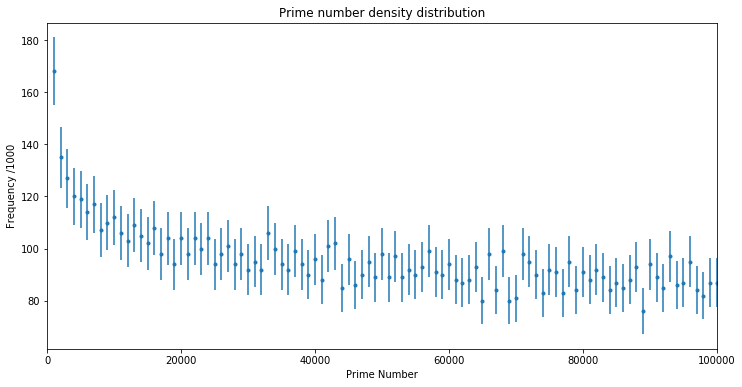

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x, y, sy, fmt='.', label='Prime number distribution')
ax.set(xlim=(xmin, xmax), 
       xlabel="Prime Number", 
       ylabel=f"Frequency /{binwidth:4d}",    # To put the bin width in the y-axis label 
       title="Prime number density distribution");

## Fitting the data:

The __[Prime Number Theorem](http://en.wikipedia.org/wiki/Prime_number_theorem)__ states, that the number of prime numbers follows roughly the function $f(x) = \frac{1}{\ln(x)}$. We have binned our prime numbers, so we must have a function with a few more degrees of freedom: $f(x) = c_0 + \frac{c_1}{\ln(x)}$, where $c_0$ and $c_1$ are constants that needs to be fitted.

We define the function to fit:

In [10]:
def fit_prime(x, c0, c1) :
    return c0 + c1 / np.log(x)

Make a chi2-regression object based on the fit function `fit_prime` and the `x`, `y` and `sy` values: 

In [11]:
chi2_object = Chi2Regression(fit_prime, x, y, sy)
minuit = Minuit(chi2_object, pedantic=False, c0=0, c1=10) # Initializes the fit with given initial values
minuit.migrad(); # Fit the function to the data

Extract the fit parameters:

In [12]:
c0, c1 = minuit.args                    # Get the output arguments
for name in minuit.parameters:          # Print the output (parameters of the fit)
    print(f"Fit value: {name} = {minuit.values[name]:.5f} +/- {minuit.errors[name]:.5f}")

Fit value: c0 = -10.52184 +/- 10.38959
Fit value: c1 = 1109.57427 +/- 109.15311


And plot the fit along with some extra text to the plot:

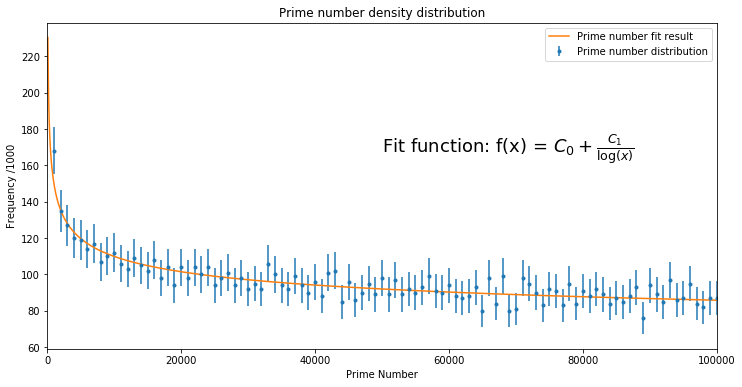

In [13]:
x_fit = np.linspace(xmin, xmax, 1000)[1:]   # Create the x-axis for the plot of the fitted function - Not from x[0] since x[0] is 0, which is not defined for the log!
y_fit = fit_prime(x_fit, c0, c1)    

ax.plot(x_fit, y_fit, '-', label='Prime number fit result')

ax.text(0.5, 0.6, r'Fit function: f(x) = $C_0 + \frac{C_1}{\log (x)}$', transform = ax.transAxes, fontdict={'size': 18}); # transform so relative coordinates
ax.legend(loc='best')

fig

We also want to extract the $\chi^2$ value (see `IntroToPlottingAndFitting.ipynb` if the command below is unclear):

In [14]:
chi2_val = minuit.fval

And the number of degrees of freedom:

In [15]:
N_NotEmptyBin = len(y > 0)
Ndof = N_NotEmptyBin - len(minuit.args)            # Number of degrees-of-freedom

We calculate the $\chi^2$ probability:

In [16]:
from scipy import stats
chi2_prob =  stats.chi2.sf(chi2_val, Ndof)

And add the fit information to the plot:

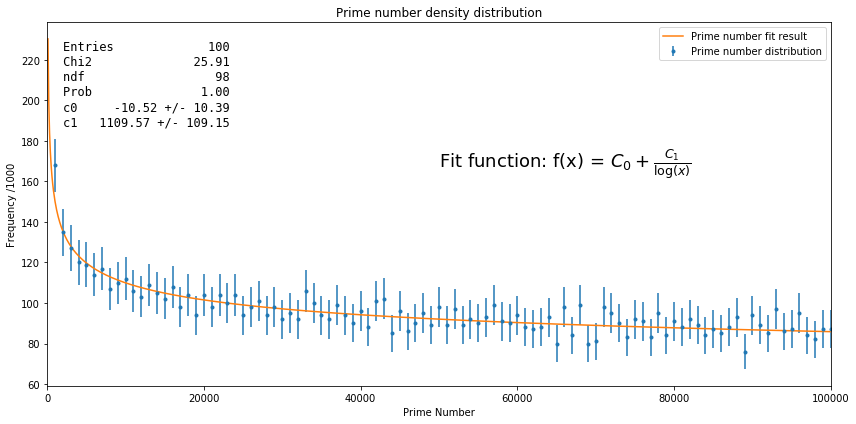

In [17]:
d = {'Entries':  N_NotEmptyBin,
     'Chi2':     chi2_val,
     'ndf':      Ndof,
     'Prob':     chi2_prob,
     'c0':       [minuit.values['c0'], minuit.errors['c0']],
     'c1':       [minuit.values['c1'], minuit.errors['c1']]
    }

text = nice_string_output(d, extra_spacing=-2, decimals=2)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=12)
fig.tight_layout()
fig

Finally we save the plots if save_plots is True:

In [18]:
if save_plots:
    fig.savefig('PrimeNumberDistribution.pdf', dpi=600)